In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import matplotlib.patches as mpatches
import os
import math
import random
from scipy.stats import ranksums
from scipy.stats import chi2_contingency

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
#modified is the normal gtf without the first two lines below
# stringtie --merge 60541_transcripts.gtf 60542_transcripts.gtf 60543_transcripts.gtf 60544_transcripts.gtf 60545_transcripts.gtf 60546_transcripts.gtf 60547_transcripts.gtf 60548_transcripts.gtf -o afran_genome_annotation_0.5.gtf -F 0 -T 0.5
# StringTie version 2.2.1
fran_gtf=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/1.stringtie/afran_genome_annotation_0.5_2_modified.gtf",sep="\t",header=None)
fran_gtf_2=fran_gtf[[0,2,3,8]]
fran_gtf_2=fran_gtf_2[fran_gtf_2[2]=='transcript']
fran_gtf_2['gene_id']=fran_gtf_2[8].str.split(';',expand=True)[0]
fran_gtf_2=fran_gtf_2[[0,2,3,'gene_id']].drop_duplicates(subset='gene_id', keep="first")
fran_gtf_2['gene_id']=fran_gtf_2['gene_id'].str[9:-1]

In [4]:
seurat_clusters=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/seurat_clusters_cells_integrated_DUBStepR_3_2.txt",sep=",")

In [5]:
normalized_exp=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/normalized_expression_DUBStepR_3_2.csv",sep=",",low_memory=False)
#normalized_exp=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/counts_DUBStepR_3_2.csv",sep=",",low_memory=False)

In [6]:
merged_normalized=pd.merge(normalized_exp,fran_gtf_2,left_on='gene',right_on='gene_id')

In [7]:
del normalized_exp

In [8]:
W_scaffolds=['scaffold000049W',
'scaffold000218W',
'scaffold000121W',
'scaffold000336W',
'scaffold000179W',
'scaffold000243W',
'scaffold000334W',
'scaffold000030W',
'scaffold000094W',
'scaffold000085W',
'scaffold000133W',
'scaffold000315W',
'scaffold000444W',
'scaffold000018W',
'scaffold000222W',
'scaffold000265W',
'scaffold000119W',
'scaffold000294W',
'scaffold000196W',
'scaffold000043W',
'scaffold000136W',
'scaffold000131W',
'scaffold000032W',
'scaffold000274W',
'scaffold000023W',
'scaffold000046W',
'scaffold000324W',
'scaffold000330W',
'scaffold000370W',
'scaffold000183W',
'scaffold000141W',
'scaffold000272W',
'scaffold000232W',
'scaffold000031W',
'scaffold000132W',
'scaffold000116W',
'scaffold000152W',
'scaffold000068W']

In [9]:
merged_all_norm=merged_normalized[merged_normalized[0].str.contains('chr')|merged_normalized[0].isin(W_scaffolds)]

In [16]:
def windows_and_strata(df2,seurat_clusters):
    df=df2.copy()
    df.loc[
      ((df[0]!='chr6')&(~df[0].str.contains('W'))), 
      'strata'
    ] = 'Autosomal'
    df.loc[
      ((df[0]=='chr6')&(df[3]<=45665001)), 
      'strata'
    ] = 'pseudo'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 45665001.0) & (df[3] <= 48665001))))
    , 
      'strata'
    ] = 'S1'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 48665001) & (df[3] <= 53325001))|((df[3] > 53585001) & (df[3] <= 54575001))|((df[3] > 54735001) & (df[3] <= 61725001))))
    , 
      'strata'
    ] = 'S0'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 61725001.0) & (df[3] <= 66725001))))
    , 
      'strata'
    ] = 'S2'
    df.loc[
      ((df[0].str.contains('W'))), 
      'strata'
    ] = 'W'
    df_2=df.drop([0,2,3,'gene','gene_id'],axis=1).groupby(["strata"]).mean().T.reset_index()
    df_3=pd.merge(seurat_clusters,df_2,left_on='barcodes',right_on='index')
    #for j in [1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]:
    #    for i in np.arange(0,math.floor(len(df[df[0]=='chr'+str(j)])/len(df[df['strata'+str(strata)]==str(strata)])),1):
    #        df.loc[df['gene'].isin(df[df[0]=='chr'+str(j)][i*len(df[df['strata'+str(strata)]==str(strata)]):(i*len(df[df['strata'+str(strata)]==str(strata)])+len(df[df['strata'+str(strata)]==str(strata)]))]['gene'].tolist()), 'strata' +str(strata)] = 'chr'+str(j)+'bin' +str(i)
    return df,df_3

In [17]:
raw,results=windows_and_strata(merged_all_norm,seurat_clusters)

In [ ]:
results=results[results['Autosomal']>0]

In [18]:
results['S0/Auto']=results['S0']/results['Autosomal']
results['pseudo/Auto']=results['pseudo']/results['Autosomal']
results['S1/Auto']=results['S1']/results['Autosomal']
results['S2/Auto']=results['S2']/results['Autosomal']
results['W/Auto']=results['W']/results['Autosomal']
results['S0/Auto']=results['S0/Auto']+(1-results[results['seurat_clusters'].isin([2,0,4])]['S0/Auto'].median())#-df_3[df_3['seurat_clusters'].isin([2,0,4])]['S0/Auto'].mean()
results['pseudo/Auto']=results['pseudo/Auto']+(1-results[results['seurat_clusters'].isin([2,0,4])]['pseudo/Auto'].median())
results['S1/Auto']=results['S1/Auto']+(1-results[results['seurat_clusters'].isin([2,0,4])]['S1/Auto'].median())
results['S2/Auto']=results['S2/Auto']+(1-results[results['seurat_clusters'].isin([2,0,4])]['S2/Auto'].median())
results['W/Auto']=results['W/Auto']+(1-results[results['seurat_clusters'].isin([2,0,4])]['W/Auto'].median())
#df_3 = df_3.rename(columns={i: str(strata)+'/'+i})

In [51]:
#S0_results,S0_results_raw=windows_and_strata('S0',merged_all_norm,seurat_clusters)
#pseudo_results,pseudo_results_raw=windows_and_strata('pseudo',merged_all_norm,seurat_clusters)

In [52]:
#S0_results['mean_all_rows_S0']=S0_results.filter(regex='S0/chr').mean(axis=1)
#S0_results['mean_all_rows_S0']=S0_results['mean_all_rows_S0']-np.median(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_S0'])
#pseudo_results['mean_all_rows_pseudo']=pseudo_results.filter(regex='pseudo/chr').mean(axis=1)
#pseudo_results['mean_all_rows_pseudo']=pseudo_results['mean_all_rows_pseudo']-np.median(pseudo_results[pseudo_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_pseudo'])

In [140]:
#results[['barcodes','S0/Auto']].to_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/ATAC/atac_classes/review/S0_results_arbitrary_17_06_2024.txt",sep=",",index=False)

In [20]:
#exp[['barcodes','zone']].to_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/5.replicate_4/counts_region/zones_all_clusters_expression_19_06_2024.txt",sep="\t",index=False)

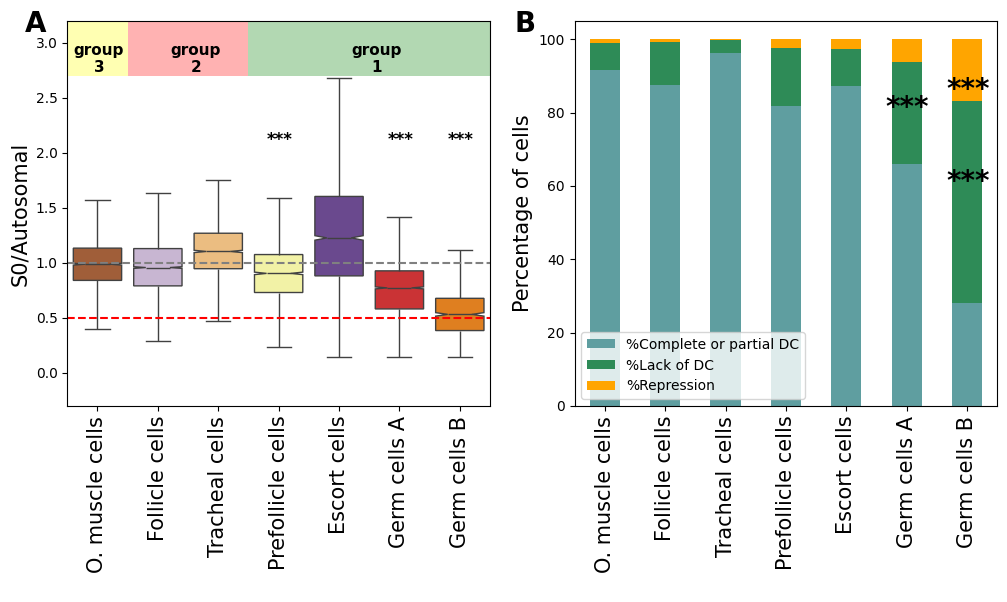

In [32]:
S0_results=results
#plt.figure(figsize=(10, 5))
#plt.subplot(2,1,0)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
my_pal ={0:'#cab2d6',1:'#e31a1c',2:'#b15928',3:'#6a3d9a',4:'#fdbf6f',5:'#ffff99',6:'#ff7f00'}
sns.boxplot(x='seurat_clusters', y='S0/Auto', data=S0_results,showfliers=False,order=[2,0,4,5,3,1,6],hue='seurat_clusters',palette=my_pal,ax=axes[0],notch=True,legend=False)
axes[0].hlines(1,-0.5,6.5,color="gray",linestyle='dashed')
axes[0].hlines(0.5,-0.5,6.5,color="red",linestyle='dashed')
#axes[0].hlines(np.median(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])+1,-0.5,6.5,color="red",linestyle='dashed')
#axes[0].vlines(0.5,-3.6,3,color="black",linewidth=1)
#axes[0].vlines(2.5,-3.6,3,color="black",linewidth=1)
axes[0].text(4.2, 3, 'group\n    1',fontsize=11, fontweight='bold', va='top')
axes[0].text(-1.2, 3.3, 'A',fontsize=20, fontweight='bold', va='top')
axes[0].text(1.2, 3, 'group\n    2',fontsize=11, fontweight='bold', va='top')
axes[0].text(-0.4, 3, 'group\n    3',fontsize=11,fontweight='bold', va='top')
axes[0].set_ylim(ymax=3.2,ymin=-0.3)
axes[0].set_xlim(xmax=6.5,xmin=-0.5)
axes[0].fill_between([2.5,6.5], 2.7, 4,facecolor='green', alpha=0.3,zorder=0)
axes[0].fill_between([0.5,2.5], 2.7, 4,facecolor='red', alpha=0.3,zorder=0)
axes[0].fill_between([-0.5,0.5],2.7, 4,facecolor='yellow', alpha=0.3,zorder=0)
axes[0].set_ylabel('S0/Autosomal',fontsize=15)
axes[0].set_xlabel(' ')
axes[0].text(2.8, 2.2, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([5])]['S0/Auto'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['S0/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(4.8, 2.2, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([1])]['S0/Auto'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['S0/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(5.8, 2.2, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([6])]['S0/Auto'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['S0/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[0].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=15)
exp=S0_results
exp['mean_all_rows']=exp['S0/Auto']
exp.loc[
  (exp['mean_all_rows']>0.66), 
  'zone'
] = 'DC'
exp.loc[
  (exp['mean_all_rows']<=0.66)&(exp['mean_all_rows']>0.33), 
  'zone'
] = 'Lack of DC'
exp.loc[
  (exp['mean_all_rows']<=0.33), 
  'zone'
] = 'Repression'
Zones_1=pd.DataFrame(exp.groupby('seurat_clusters')['zone'].value_counts()).unstack(fill_value=0).reset_index(drop=True).reset_index(drop=True)
Zones_1.columns = Zones_1.columns.droplevel()
Zones_1=Zones_1.reset_index()
Zones_1['%Complete or partial DC']=(Zones_1['DC']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
Zones_1['%Repression']=(Zones_1['Repression']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
Zones_1['%Lack of DC']=(Zones_1['Lack of DC']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
exp_plot=Zones_1[["%Complete or partial DC","%Lack of DC","%Repression"]].reindex([2,0,4,5,3,1,6]).plot.bar(stacked=True,color=['cadetblue','seagreen',"orange"],ax=axes[1])
exp_plot.legend(loc=3) 
plt.ylabel("Percentage of cells",fontsize=15)
axes[1].set_xlabel(' ')
Zones_1_stats=Zones_1[["%Complete or partial DC","%Lack of DC","%Repression"]].reindex([2,0,4,5,3,1,6]).T.reset_index()#[[2,1]]
#Zones_1_stats['somatic']=np.median([Zones_1_stats[2].astype(float),Zones_1_stats[0].astype(float),Zones_1_stats[4].astype(float)])
Zones_1_stats['somatic']=Zones_1_stats[[2,0,4]].median(axis=1)
Zones_1_stats=Zones_1_stats.drop([2,0,4],axis=1)
Zones_1_stats.loc[len(Zones_1_stats.index)] = np.append(np.array(['%Not_repressed']),np.array(Zones_1_stats[Zones_1_stats['zone']=='%Lack of DC'][[5,3,1,6,'somatic']].astype(float))+np.array(Zones_1_stats[Zones_1_stats['zone']=='%Complete or partial DC'][[5,3,1,6,'somatic']].astype(float)))#].insert(0, 'NI')
Zones_1_stats.loc[len(Zones_1_stats.index)] = np.append(np.array(['%No_Lack_of_DC']),np.array(Zones_1_stats[Zones_1_stats['zone']=='%Repression'][[5,3,1,6,'somatic']].astype(float))+np.array(Zones_1_stats[Zones_1_stats['zone']=='%Complete or partial DC'][[5,3,1,6,'somatic']].astype(float)))#].insert(0, 'NI')
Zones_1_stats_N=Zones_1_stats[(Zones_1_stats['zone']=='%complete or partial DC')|(Zones_1_stats['zone']=="%Lack of DC")|(Zones_1_stats['zone']=="%Repression")]
Zones_1_stats_NI=Zones_1_stats[(Zones_1_stats['zone']=='%Not_repressed')|(Zones_1_stats['zone']=="%Repression")]
Zones_1_stats_NDC=Zones_1_stats[(Zones_1_stats['zone']=='%No_Lack_of_DC')|(Zones_1_stats['zone']=="%Lack of DC")]
axes[1].text(4.65, 85, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',1]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
#axes[1].text(4.7, 100, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NI[['somatic',1]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(5.65, 65, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',6]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(5.65, 90, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NI[['somatic',6]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
#axes[1].text(2.65, 90, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',5]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(-1.5, 108, 'B',fontsize=20, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[1].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=15)
#plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/8.Jupyter_notebooks_for_submission/review_figures/Repression_GEX_v3_review_figure_arbitrary_supplementary_text.png',bbox_inches='tight',facecolor='white',dpi=1000)

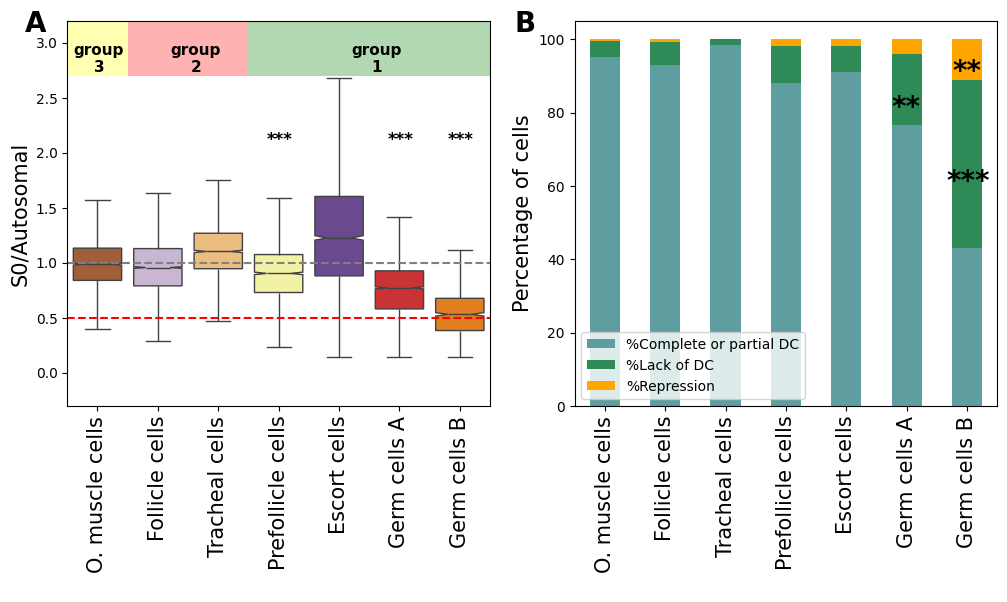

In [33]:
S0_results=results
#plt.figure(figsize=(10, 5))
#plt.subplot(2,1,0)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
my_pal ={0:'#cab2d6',1:'#e31a1c',2:'#b15928',3:'#6a3d9a',4:'#fdbf6f',5:'#ffff99',6:'#ff7f00'}
sns.boxplot(x='seurat_clusters', y='S0/Auto', data=S0_results,showfliers=False,order=[2,0,4,5,3,1,6],hue='seurat_clusters',palette=my_pal,ax=axes[0],notch=True,legend=False)
axes[0].hlines(1,-0.5,6.5,color="gray",linestyle='dashed')
axes[0].hlines(0.5,-0.5,6.5,color="red",linestyle='dashed')
#axes[0].hlines(np.median(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'])+1,-0.5,6.5,color="red",linestyle='dashed')
#axes[0].vlines(0.5,-3.6,3,color="black",linewidth=1)
#axes[0].vlines(2.5,-3.6,3,color="black",linewidth=1)
axes[0].text(4.2, 3, 'group\n    1',fontsize=11, fontweight='bold', va='top')
axes[0].text(-1.2, 3.3, 'A',fontsize=20, fontweight='bold', va='top')
axes[0].text(1.2, 3, 'group\n    2',fontsize=11, fontweight='bold', va='top')
axes[0].text(-0.4, 3, 'group\n    3',fontsize=11,fontweight='bold', va='top')
axes[0].set_ylim(ymax=3.2,ymin=-0.3)
axes[0].set_xlim(xmax=6.5,xmin=-0.5)
axes[0].fill_between([2.5,6.5], 2.7, 4,facecolor='green', alpha=0.3,zorder=0)
axes[0].fill_between([0.5,2.5], 2.7, 4,facecolor='red', alpha=0.3,zorder=0)
axes[0].fill_between([-0.5,0.5],2.7, 4,facecolor='yellow', alpha=0.3,zorder=0)
axes[0].set_ylabel('S0/Autosomal',fontsize=15)
axes[0].set_xlabel(' ')
axes[0].text(2.8, 2.2, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([5])]['S0/Auto'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['S0/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(4.8, 2.2, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([1])]['S0/Auto'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['S0/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0].text(5.8, 2.2, convert_pvalue_to_asterisks(ranksums(S0_results[S0_results['seurat_clusters'].isin([6])]['S0/Auto'],S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['S0/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[0].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=15)
exp=S0_results
exp['mean_all_rows']=exp['S0/Auto']
exp.loc[
  (exp['mean_all_rows']>np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],5)), 
  'zone'
] = 'DC'
exp.loc[
  (exp['mean_all_rows']<=np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],5))&(exp['mean_all_rows']>np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],5)*0.5), 
  'zone'
] = 'Lack of DC'
exp.loc[
  (exp['mean_all_rows']<=np.percentile(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows'],5)*0.5), 
  'zone'
] = 'Repression'
Zones_1=pd.DataFrame(exp.groupby('seurat_clusters')['zone'].value_counts()).unstack(fill_value=0).reset_index(drop=True).reset_index(drop=True)
Zones_1.columns = Zones_1.columns.droplevel()
Zones_1=Zones_1.reset_index()
Zones_1['%Complete or partial DC']=(Zones_1['DC']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
Zones_1['%Repression']=(Zones_1['Repression']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
Zones_1['%Lack of DC']=(Zones_1['Lack of DC']/(Zones_1['DC']+Zones_1['Repression']+Zones_1['Lack of DC']))*100
exp_plot=Zones_1[["%Complete or partial DC","%Lack of DC","%Repression"]].reindex([2,0,4,5,3,1,6]).plot.bar(stacked=True,color=['cadetblue','seagreen',"orange"],ax=axes[1])
exp_plot.legend(loc=3) 
plt.ylabel("Percentage of cells",fontsize=15)
axes[1].set_xlabel(' ')
Zones_1_stats=Zones_1[["%Complete or partial DC","%Lack of DC","%Repression"]].reindex([2,0,4,5,3,1,6]).T.reset_index()#[[2,1]]
#Zones_1_stats['somatic']=np.median([Zones_1_stats[2].astype(float),Zones_1_stats[0].astype(float),Zones_1_stats[4].astype(float)])
Zones_1_stats['somatic']=Zones_1_stats[[2,0,4]].median(axis=1)
Zones_1_stats=Zones_1_stats.drop([2,0,4],axis=1)
Zones_1_stats.loc[len(Zones_1_stats.index)] = np.append(np.array(['%Not_repressed']),np.array(Zones_1_stats[Zones_1_stats['zone']=='%Lack of DC'][[5,3,1,6,'somatic']].astype(float))+np.array(Zones_1_stats[Zones_1_stats['zone']=='%Complete or partial DC'][[5,3,1,6,'somatic']].astype(float)))#].insert(0, 'NI')
Zones_1_stats.loc[len(Zones_1_stats.index)] = np.append(np.array(['%No_Lack_of_DC']),np.array(Zones_1_stats[Zones_1_stats['zone']=='%Repression'][[5,3,1,6,'somatic']].astype(float))+np.array(Zones_1_stats[Zones_1_stats['zone']=='%Complete or partial DC'][[5,3,1,6,'somatic']].astype(float)))#].insert(0, 'NI')
Zones_1_stats_N=Zones_1_stats[(Zones_1_stats['zone']=='%complete or partial DC')|(Zones_1_stats['zone']=="%Lack of DC")|(Zones_1_stats['zone']=="%Repression")]
Zones_1_stats_NI=Zones_1_stats[(Zones_1_stats['zone']=='%Not_repressed')|(Zones_1_stats['zone']=="%Repression")]
Zones_1_stats_NDC=Zones_1_stats[(Zones_1_stats['zone']=='%No_Lack_of_DC')|(Zones_1_stats['zone']=="%Lack of DC")]
axes[1].text(4.75, 85, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',1]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
#axes[1].text(4.7, 100, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NI[['somatic',1]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(5.65, 65, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',6]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(5.75, 95, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NI[['somatic',6]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
#axes[1].text(2.65, 90, convert_pvalue_to_asterisks(chi2_contingency(np.array(Zones_1_stats_NDC[['somatic',5]].astype(float))).pvalue),fontsize=20, fontweight='bold', va='top')
axes[1].text(-1.5, 108, 'B',fontsize=20, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[1].set_xticks(np.arange(0,7), region,rotation = 90,fontsize=15)
#plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/8.Jupyter_notebooks_for_submission/review_figures/Repression_GEX_v3_review_figure_arbitrary_percentile.png',bbox_inches='tight',facecolor='white',dpi=1000)

In [176]:
Zones_1_stats

,zone,5,3,1,6,somatic
0,%Complete or partial DC,88.078603,90.96563,76.534296,42.97619,95.205274
1,%Lack of DC,10.087336,7.135843,19.383505,45.833333,4.255319
2,%Repression,1.834061,1.898527,4.082199,11.190476,0.539407
3,%Not_repressed,98.16593886462883,98.10147299509,95.9178006109414,88.80952380952381,99.46059334731795
4,%No_Lack_of_DC,89.91266375545851,92.86415711947626,80.61649541793946,54.16666666666667,95.74468085106383


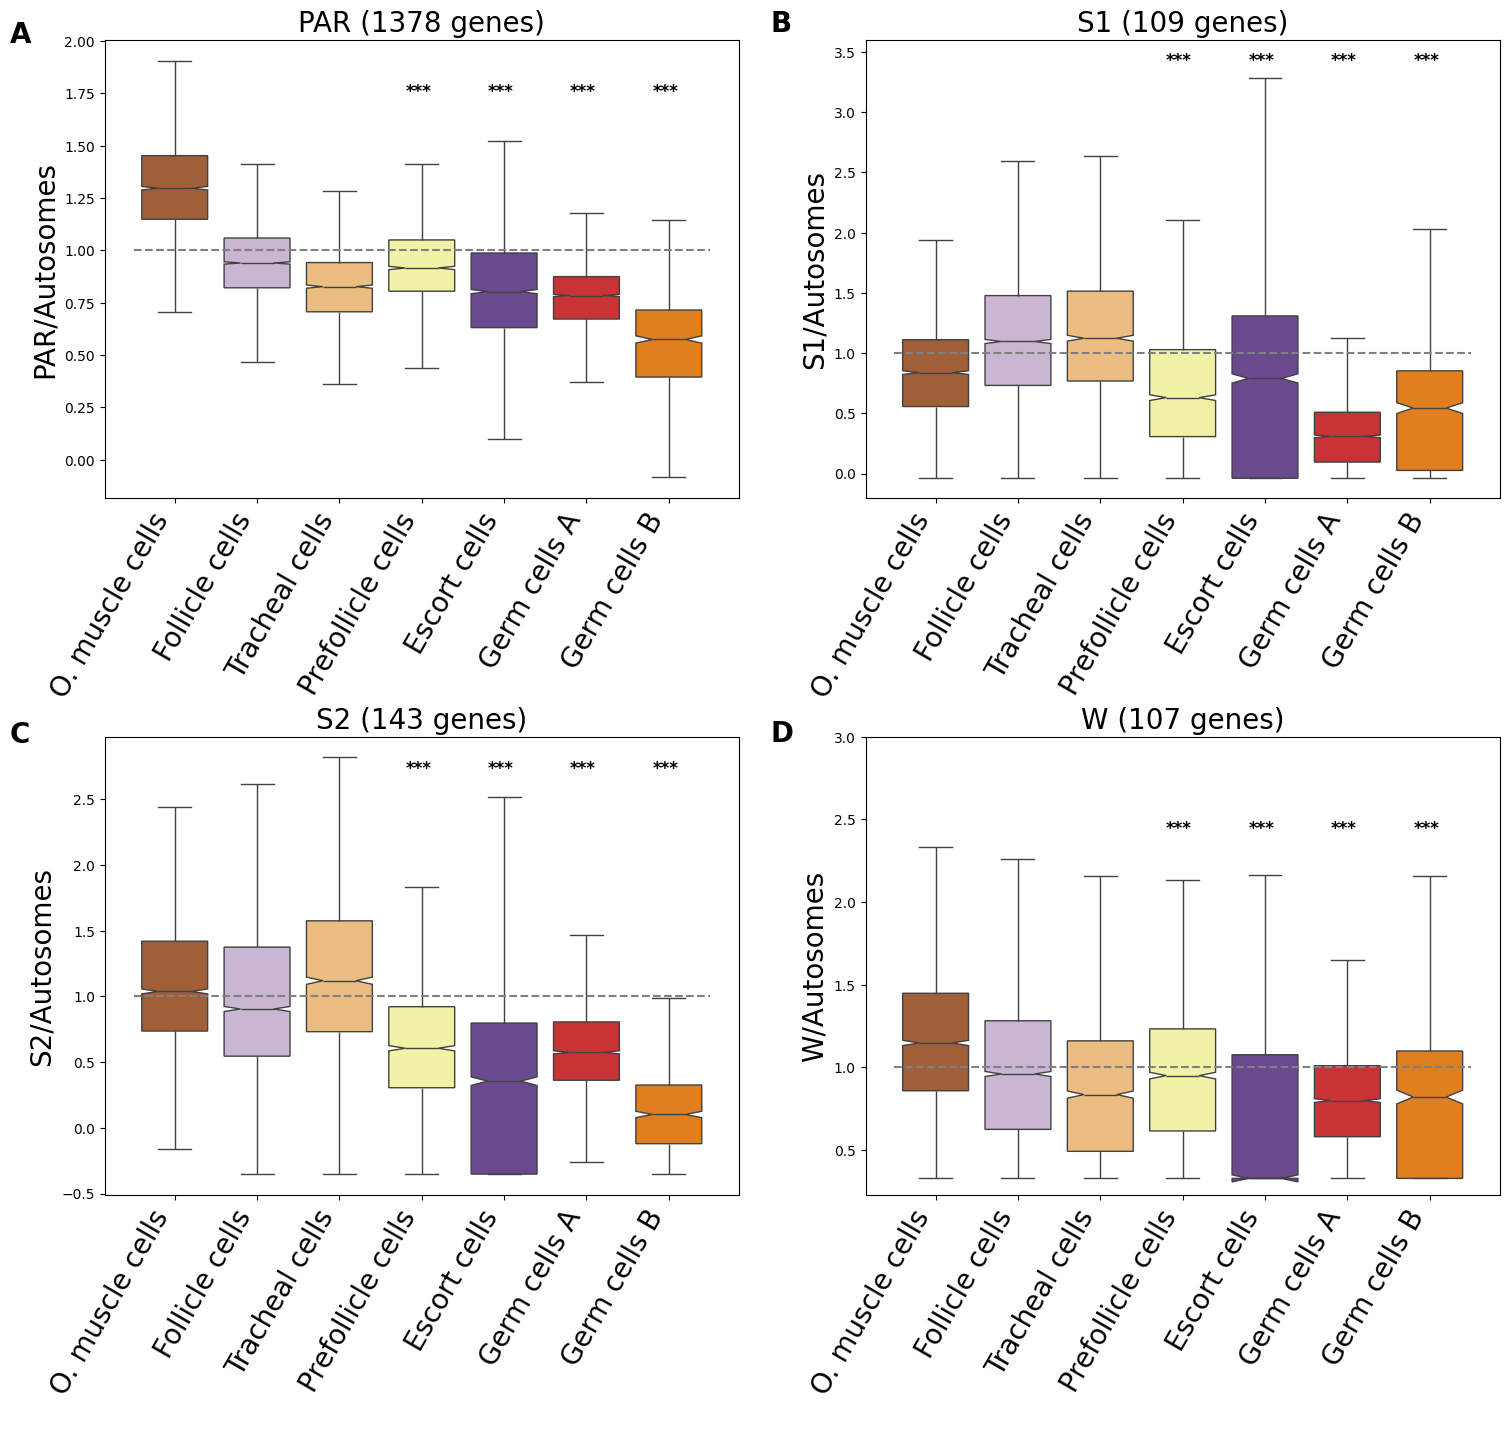

In [34]:
#plt.figure(figsize=(10, 5))
#plt.subplot(2,1,0)
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18, 15),gridspec_kw={'hspace':0.52})
my_pal ={0:'#cab2d6',1:'#e31a1c',2:'#b15928',3:'#6a3d9a',4:'#fdbf6f',5:'#ffff99',6:'#ff7f00'}
sns.boxplot(x='seurat_clusters', y='pseudo/Auto', data=results,showfliers=False,order=[2,0,4,5,3,1,6],palette=my_pal,ax=axes[0,0],notch=True,hue='seurat_clusters',legend=False)
axes[0,0].hlines(np.median(results[results['seurat_clusters'].isin([2,0,4])]['pseudo/Auto']),-0.5,6.5,color="gray",linestyle='dashed')
#axes[0].hlines(np.median(results[results['seurat_clusters'].isin([2,0,4])]['pseudo/Auto'])-1,-0.5,6.5,color="red",linestyle='dashed')
#axes[0].set_ylim(ymax=4,ymin=-0.5)
#axes[0].set_ylim(ymax=10,ymin=-10)
#axes[0].fill_between([2.5,6.5], 2, 3,facecolor='green', alpha=0.5)
#axes[0].fill_between([0.5,2.5], 2, 3,facecolor='red', alpha=0.5)
#axes[0].fill_between([-0.5,0.5], 2, 3,facecolor='yellow', alpha=0.5)
axes[0,0].set_title('PAR (1378 genes)',fontsize=20)
axes[0,0].text(-2, 2.1, 'A',fontsize=20, fontweight='bold', va='top')
axes[0,0].set_ylabel('PAR/Autosomes',fontsize=20)
axes[0,0].set_xlabel(' ')
axes[0,0].text(2.8, 1.8, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([5])]['pseudo/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['pseudo/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0,0].text(3.8, 1.8, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([3])]['pseudo/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['pseudo/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0,0].text(4.8, 1.8, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([1])]['pseudo/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['pseudo/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0,0].text(5.8, 1.8, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([6])]['pseudo/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['pseudo/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[0,0].set_xticks(np.arange(0,7), region,rotation = 60,fontsize=20,ha="right")
sns.boxplot(x='seurat_clusters', y='S1/Auto', data=results,showfliers=False,order=[2,0,4,5,3,1,6],palette=my_pal,ax=axes[0,1],notch=True,hue='seurat_clusters',legend=False)
axes[0,1].text(-2, 3.85, 'B',fontsize=20, fontweight='bold', va='top')
axes[0,1].hlines(np.median(results[results['seurat_clusters'].isin([2,0,4])]['S1/Auto']),-0.5,6.5,color="gray",linestyle='dashed')
#axes[1].hlines(np.median(results[results['seurat_clusters'].isin([2,0,4])]['S1/Auto'])-1,-0.5,6.5,color="red",linestyle='dashed')
#axes[1].text(4.2, 2.8, 'group 3',fontsize=10, fontweight='bold', va='top')
#axes[1].text(-0.4, 2, 'A',fontsize=20, fontweight='bold', va='top')
#axes[1].text(1.3, 2.8, 'group 2',fontsize=10, fontweight='bold', va='top')
#axes[1].text(-0.4, 2.8, 'group 1',fontsize=10, fontweight='bold', va='top')
axes[0,1].set_ylim(ymax=3.6)
#axes[1].set_ylim(ymax=1.5,ymin=-2)
#axes[1].fill_between([2.5,6.5], 7.5, 10,facecolor='green', alpha=0.5)
#axes[1].fill_between([0.5,2.5], 2, 3,facecolor='red', alpha=0.5)
#axes[1].fill_between([-0.5,0.5], 2, 3,facecolor='yellow', alpha=0.5)
axes[0,1].set_ylabel('S1/Autosomes',fontsize=20)
axes[0,1].set_xlabel(' ')
axes[0,1].text(2.8, 3.5, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([5])]['S1/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['S1/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0,1].text(3.8, 3.5, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([3])]['S1/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['S1/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0,1].text(4.8, 3.5, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([1])]['S1/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['S1/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0,1].text(5.8, 3.5, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([6])]['S1/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['S1/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[0,1].set_title('S1 (109 genes)',fontsize=20)
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[0,1].set_xticks(np.arange(0,7), region,rotation = 60,fontsize=20,ha="right")
sns.boxplot(x='seurat_clusters', y='S2/Auto', data=results,showfliers=False,order=[2,0,4,5,3,1,6],palette=my_pal,ax=axes[1,0],notch=True,hue='seurat_clusters',legend=False)
axes[1,0].text(-2, 3.1, 'C',fontsize=20, fontweight='bold', va='top')
axes[1,0].hlines(np.median(results[results['seurat_clusters'].isin([2,0,4])]['S2/Auto']),-0.5,6.5,color="gray",linestyle='dashed')
#axes[2].hlines(np.median(results[results['seurat_clusters'].isin([2,0,4])]['S2/Auto'])-1,-0.5,6.5,color="red",linestyle='dashed')
#axes[2].text(4.2, 2.8, 'group 3',fontsize=10, fontweight='bold', va='top')
#axes[2].text(-0.4, 2, 'A',fontsize=20, fontweight='bold', va='top')
#axes[2].text(1.3, 2.8, 'group 2',fontsize=10, fontweight='bold', va='top')
#axes[2].text(-0.4, 2.8, 'group 1',fontsize=10, fontweight='bold', va='top')
#axes[2].set_ylim(ymax=10)
#axes[2].set_ylim(ymax=1.5,ymin=-2)
#axes[2].fill_between([2.5,6.5], 2, 3,facecolor='green', alpha=0.5)
#axes[2].fill_between([0.5,2.5], 2, 3,facecolor='red', alpha=0.5)
#axes[2].fill_between([-0.5,0.5], 2, 3,facecolor='yellow', alpha=0.5)
axes[1,0].set_ylabel('S2/Autosomes',fontsize=20)
axes[1,0].set_xlabel(' ')
axes[1,0].text(2.8, 2.8, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([5])]['S2/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['S2/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[1,0].text(3.8, 2.8, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([3])]['S2/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['S2/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[1,0].text(4.8, 2.8, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([1])]['S2/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['S2/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[1,0].text(5.8, 2.8, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([6])]['S2/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['S2/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[1,0].set_title('S2 (143 genes)',fontsize=20)
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[1,0].set_xticks(np.arange(0,7), region,rotation = 60,fontsize=20,ha="right")
sns.boxplot(x='seurat_clusters', y='W/Auto', data=results,showfliers=False,order=[2,0,4,5,3,1,6],palette=my_pal,ax=axes[1,1],notch=True,hue='seurat_clusters',legend=False)
axes[1,1].text(-2, 3.1, 'D',fontsize=20, fontweight='bold', va='top')
axes[1,1].hlines(np.median(results[results['seurat_clusters'].isin([2,0,4])]['W/Auto']),-0.5,6.5,color="gray",linestyle='dashed')
#axes[3].hlines(np.median(results[results['seurat_clusters'].isin([2,0,4])]['W/Auto'])-1,-0.5,6.5,color="red",linestyle='dashed')
#axes[2].text(4.2, 2.8, 'group 3',fontsize=10, fontweight='bold', va='top')
#axes[2].text(-0.4, 2, 'A',fontsize=20, fontweight='bold', va='top')
#axes[2].text(1.3, 2.8, 'group 2',fontsize=10, fontweight='bold', va='top')
#axes[2].text(-0.4, 2.8, 'group 1',fontsize=10, fontweight='bold', va='top')
axes[1,1].set_ylim(ymax=3)
#axes[3].set_ylim(ymax=1.5,ymin=-2)
#axes[2].fill_between([2.5,6.5], 2, 3,facecolor='green', alpha=0.5)
#axes[2].fill_between([0.5,2.5], 2, 3,facecolor='red', alpha=0.5)
#axes[2].fill_between([-0.5,0.5], 2, 3,facecolor='yellow', alpha=0.5)
axes[1,1].set_ylabel('W/Autosomes',fontsize=20)
axes[1,1].set_xlabel(' ')
axes[1,1].set_title('W (107 genes)',fontsize=20)
axes[1,1].text(2.8, 2.5, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([5])]['W/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['W/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[1,1].text(3.8, 2.5, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([3])]['W/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['W/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[1,1].text(4.8, 2.5, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([1])]['W/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['W/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
axes[1,1].text(5.8, 2.5, convert_pvalue_to_asterisks(ranksums(results[results['seurat_clusters'].isin([6])]['W/Auto'],results[results['seurat_clusters'].isin([2,0,4])]['W/Auto'],alternative='less').pvalue),fontsize=12, fontweight='bold', va='top')
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
axes[1,1].set_xticks(np.arange(0,7), region,rotation = 60,fontsize=20,ha="right")
#plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/repression_all_Z_v3.png',bbox_inches='tight',facecolor='white')
#plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/8.Jupyter_notebooks_for_submission/review_figures/strata_review_figure_3.png',bbox_inches='tight',facecolor='white')

In [123]:
#exp[['barcodes','zone']].to_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/5.replicate_4/counts_region/zones_all_clusters_expression_12_06_2024.txt",sep="\t",index=False)

In [779]:
my_pal ={0:'#cab2d6',1:'#e31a1c',2:'#b15928',3:'#6a3d9a',4:'#fdbf6f',5:'#ffff99',6:'#ff7f00'}

Text(18.9, 2.75, 'Germ cells B')

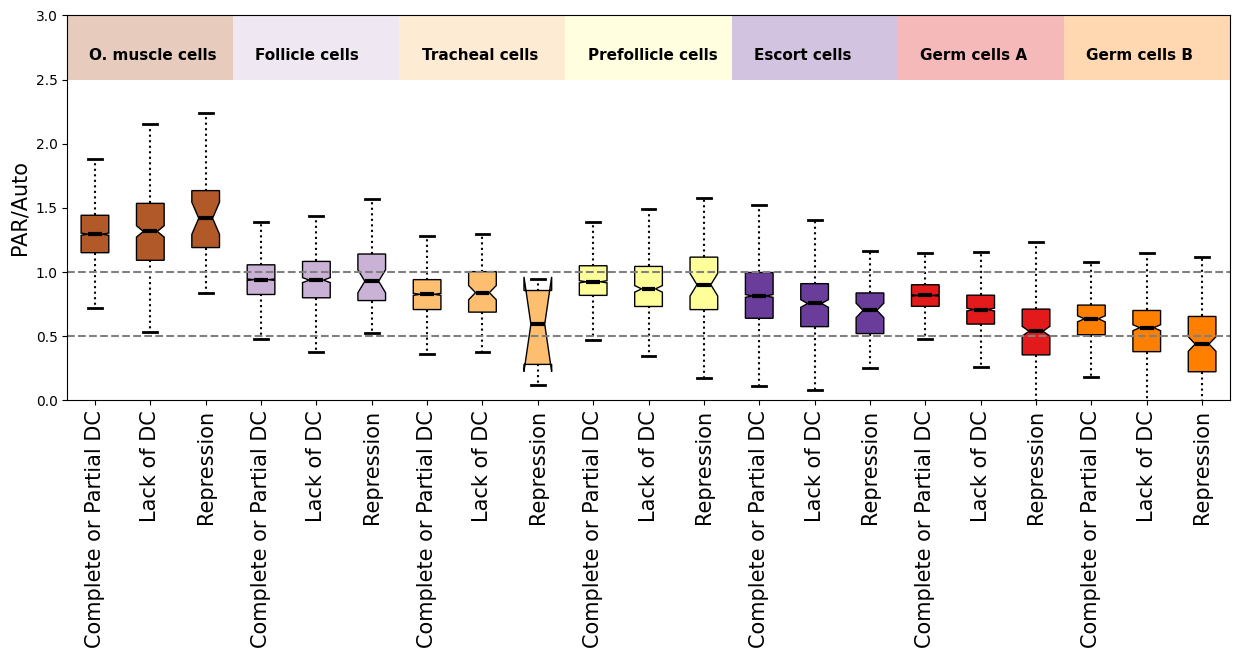

In [28]:
plt.figure(figsize=(15, 5))
bp=plt.boxplot([exp[(exp['zone']=='DC')&(exp['seurat_clusters']==2)]['pseudo/Auto'],exp[(exp['zone']=='Lack of DC')&(exp['seurat_clusters']==2)]['pseudo/Auto'],exp[(exp['zone']=='Repression')&(exp['seurat_clusters']==2)]['pseudo/Auto'],exp[(exp['zone']=='DC')&(exp['seurat_clusters']==0)]['pseudo/Auto'],exp[(exp['zone']=='Lack of DC')&(exp['seurat_clusters']==0)]['pseudo/Auto'],exp[(exp['zone']=='Repression')&(exp['seurat_clusters']==0)]['pseudo/Auto'],exp[(exp['zone']=='DC')&(exp['seurat_clusters']==4)]['pseudo/Auto'],exp[(exp['zone']=='Lack of DC')&(exp['seurat_clusters']==4)]['pseudo/Auto'],exp[(exp['zone']=='Repression')&(exp['seurat_clusters']==4)]['pseudo/Auto'],exp[(exp['zone']=='DC')&(exp['seurat_clusters']==5)]['pseudo/Auto'],exp[(exp['zone']=='Lack of DC')&(exp['seurat_clusters']==5)]['pseudo/Auto'],exp[(exp['zone']=='Repression')&(exp['seurat_clusters']==5)]['pseudo/Auto'],exp[(exp['zone']=='DC')&(exp['seurat_clusters']==3)]['pseudo/Auto'],exp[(exp['zone']=='Lack of DC')&(exp['seurat_clusters']==3)]['pseudo/Auto'],exp[(exp['zone']=='Repression')&(exp['seurat_clusters']==3)]['pseudo/Auto'],exp[(exp['zone']=='DC')&(exp['seurat_clusters']==1)]['pseudo/Auto'],exp[(exp['zone']=='Lack of DC')&(exp['seurat_clusters']==1)]['pseudo/Auto'],exp[(exp['zone']=='Repression')&(exp['seurat_clusters']==1)]['pseudo/Auto'],exp[(exp['zone']=='DC')&(exp['seurat_clusters']==6)]['pseudo/Auto'],exp[(exp['zone']=='Lack of DC')&(exp['seurat_clusters']==6)]['pseudo/Auto'],exp[(exp['zone']=='Repression')&(exp['seurat_clusters']==6)]['pseudo/Auto']],showfliers=False,notch=True,patch_artist=True)
plt.hlines(1,0.5,22,color="gray",linestyle='dashed')
plt.hlines(0.5,0.5,22,color="gray",linestyle='dashed')
plt.xlim(xmin=0.5,xmax=21.5)
plt.ylim(ymin=0,ymax=3)
colors =[my_pal[2],my_pal[2],my_pal[2],my_pal[0],my_pal[0],my_pal[0],my_pal[4],my_pal[4],my_pal[4],my_pal[5],my_pal[5],my_pal[5],my_pal[3],my_pal[3],my_pal[3],my_pal[1],my_pal[1],my_pal[1],my_pal[6],my_pal[6],my_pal[6]]
#['#cab2d6','#cab2d6','#cab2d6','#e31a1c','#e31a1c','#e31a1c','#b15928','#b15928','#b15928','#6a3d9a','#6a3d9a','#6a3d9a','#fdbf6f','#fdbf6f','#fdbf6f','#ffff99','#ffff99','#ffff99','#ff7f00','#ff7f00','#ff7f00']
#colors = ['orange','seagreen',"cadetblue"]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color) 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='black',
            linewidth = 2)
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)
plt.xticks(np.arange(1,22), ['Complete or Partial DC','Lack of DC','Repression','Complete or Partial DC','Lack of DC','Repression','Complete or Partial DC','Lack of DC','Repression','Complete or Partial DC','Lack of DC','Repression','Complete or Partial DC','Lack of DC','Repression','Complete or Partial DC','Lack of DC','Repression','Complete or Partial DC','Lack of DC','Repression'],rotation = 90,fontsize=15)
plt.ylabel("PAR/Auto",fontsize=15)
plt.fill_between([0,3.5], 2.5,3,facecolor=my_pal[2], alpha=0.3,zorder=0)
plt.fill_between([3.5,6.5], 2.5,3,facecolor=my_pal[0], alpha=0.3,zorder=0)
plt.fill_between([6.5,9.5], 2.5,3,facecolor=my_pal[4], alpha=0.3,zorder=0)
plt.fill_between([9.5,12.5], 2.5,3,facecolor=my_pal[5], alpha=0.3,zorder=0)
plt.fill_between([12.5,15.5], 2.5,3,facecolor=my_pal[3], alpha=0.3,zorder=0)
plt.fill_between([15.5,18.5], 2.5,3,facecolor=my_pal[1], alpha=0.3,zorder=0)
plt.fill_between([18.5,21.5], 2.5,3,facecolor=my_pal[6], alpha=0.3,zorder=0)
plt.text(0.9, 2.75, region[0],fontsize=11, fontweight='bold', va='top')
plt.text(0.9+3, 2.75, region[1],fontsize=11, fontweight='bold', va='top')
plt.text(0.9+3+3, 2.75, region[2],fontsize=11, fontweight='bold', va='top')
plt.text(0.9+9, 2.75, region[3],fontsize=11, fontweight='bold', va='top')
plt.text(0.9+12, 2.75, region[4],fontsize=11, fontweight='bold', va='top')
plt.text(0.9+15, 2.75, region[5],fontsize=11, fontweight='bold', va='top')
plt.text(0.9+18, 2.75, region[6],fontsize=11, fontweight='bold', va='top')
#plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/8.Jupyter_notebooks_for_submission/review_figures/PAR_expression.png',bbox_inches='tight',facecolor='white')

Text(0.5, 1.0, 'Germ cells B')

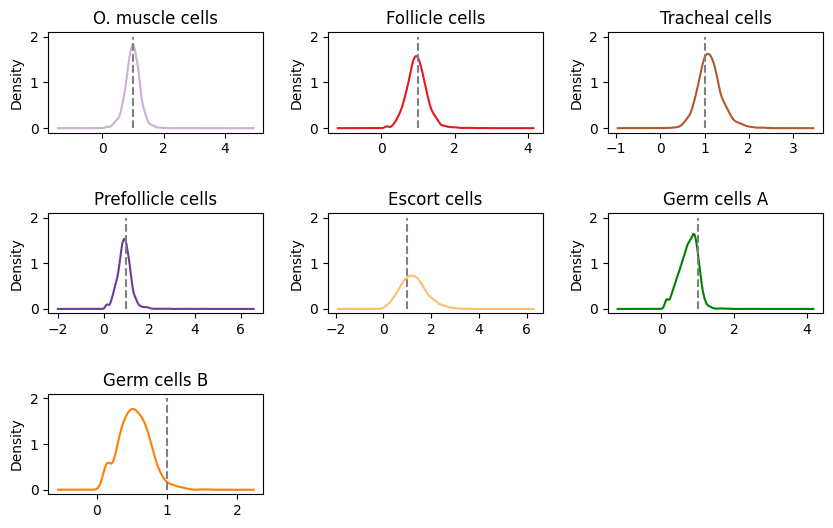

In [30]:
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
plt.figure(figsize=(10, 6))
colors =['#cab2d6','#e31a1c','#b15928','#6a3d9a','#fdbf6f','#ffff99','#ff7f00']
plt.subplots_adjust(wspace=0.30, hspace=0.8)
plt.subplot(3,3,1)
results[results['seurat_clusters']==2]['S0/Auto'].plot.kde(color=colors[0])
plt.vlines(1,0,2,color="grey",linestyle='dashed')
plt.title(region[0])
plt.subplot(3,3,2)
results[results['seurat_clusters']==0]['S0/Auto'].plot.kde(color=colors[1])
plt.vlines(1,0,2,color="grey",linestyle='dashed')
plt.title(region[1])
plt.subplot(3,3,3)
results[results['seurat_clusters']==4]['S0/Auto'].plot.kde(color=colors[2])
plt.vlines(1,0,2,color="grey",linestyle='dashed')
plt.title(region[2])
plt.subplot(3,3,4)
results[results['seurat_clusters']==5]['S0/Auto'].plot.kde(color=colors[3])
plt.vlines(1,0,2,color="grey",linestyle='dashed')
plt.title(region[3])
plt.subplot(3,3,5)
results[results['seurat_clusters']==3]['S0/Auto'].plot.kde(color=colors[4])
plt.vlines(1,0,2,color="grey",linestyle='dashed')
plt.title(region[4])
plt.subplot(3,3,6)
results[results['seurat_clusters']==1]['S0/Auto'].plot.kde(color='green')
plt.vlines(1,0,2,color="grey",linestyle='dashed')
plt.title(region[5])
plt.subplot(3,3,7)
results[results['seurat_clusters']==6]['S0/Auto'].plot.kde(color=colors[6])
plt.vlines(1,0,2,color="grey",linestyle='dashed')
plt.title(region[6])
#plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/8.Jupyter_notebooks_for_submission/review_figures/distribution_review_figure_with_lines.png',bbox_inches='tight',facecolor='white')